In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    f1_score
)

import shap


In [2]:
df = pd.read_csv("bank.csv")
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [4]:
df['deposit'].value_counts()

deposit
no     5873
yes    5289
Name: count, dtype: int64

In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [7]:
df['deposit'] = df['deposit'].map({'yes':1,'no':0})

In [8]:
X = df.drop('deposit', axis=1)
y = df['deposit']

In [9]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,stratify=y,random_state=42)

In [14]:
lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=20000))
])

lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)
lr_probs = lr_pipeline.predict_proba(X_test)[:,1]


In [15]:
rf_pipeline = Pipeline([('prep', preprocessor),('model', RandomForestClassifier(n_estimators=200, random_state=42))])

rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)
rf_probs = rf_pipeline.predict_proba(X_test)[:,1]


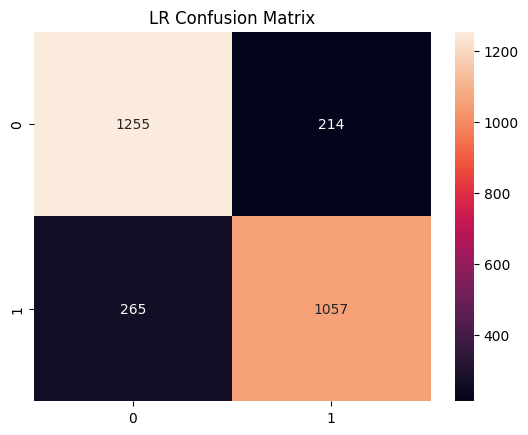

In [16]:
cm = confusion_matrix(y_test, lr_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("LR Confusion Matrix")
plt.show()

In [17]:
print("LR F1 Score:", f1_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))


LR F1 Score: 0.8152718858465098
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1469
           1       0.83      0.80      0.82      1322

    accuracy                           0.83      2791
   macro avg       0.83      0.83      0.83      2791
weighted avg       0.83      0.83      0.83      2791



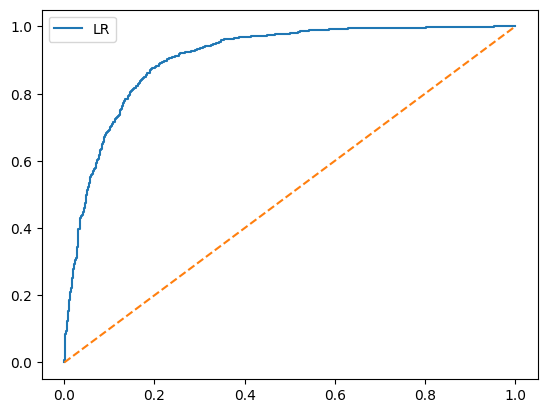

LR AUC: 0.9066481361140835


In [18]:
fpr, tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(fpr, tpr, label="LR")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

print("LR AUC:", roc_auc_score(y_test, lr_probs))

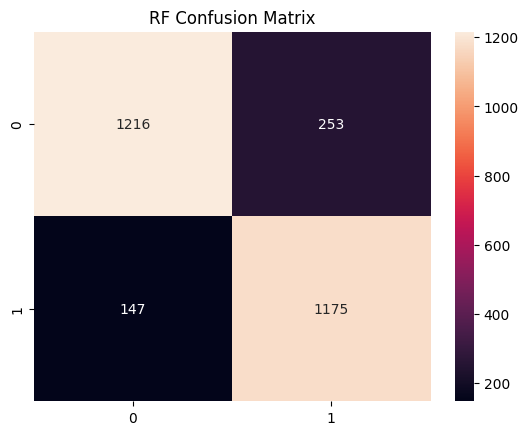

In [19]:
cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("RF Confusion Matrix")
plt.show()

In [20]:
print("RF F1 Score:", f1_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

RF F1 Score: 0.8545454545454545
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1469
           1       0.82      0.89      0.85      1322

    accuracy                           0.86      2791
   macro avg       0.86      0.86      0.86      2791
weighted avg       0.86      0.86      0.86      2791



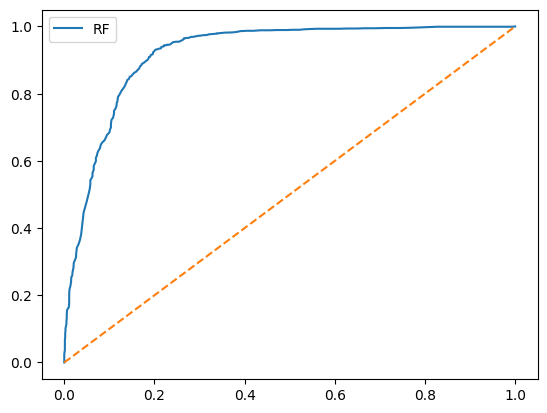

RF AUC: 0.9197461094593355


In [21]:
fpr, tpr, _ = roc_curve(y_test, rf_probs)
plt.plot(fpr, tpr, label="RF")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

print("RF AUC:", roc_auc_score(y_test, rf_probs))

In [ ]:
# Transform data
X_train_enc = rf_pipeline.named_steps['prep'].transform(X_train)
X_test_enc = rf_pipeline.named_steps['prep'].transform(X_test)

rf_model = rf_pipeline.named_steps['model']

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_enc)

In [ ]:
shap.summary_plot(shap_values[1], X_test_enc)

In [ ]:
for i in range(5):
    print(f"Explaining prediction {i}")
    
    shap.force_plot(explainer.expected_value[1],shap_values[1][i],matplotlib=True)